# Multi-class with Frequency Domain Features

### This code is for multi-class classification with a small set of data having frequency domain features. 
### Three classes are: 0: Normal Operation, 1: Human Intervention, 2: Fault Operation (jamming)
### For each class, # of samples are 100.
### Features include time series vibration data, level data, vibration motor amplitude, throttle gate,  and top five frequency features. Total features 29. Only features that are of significance considered for training and prediction.

# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import datetime

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import RidgeClassifierCV

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer ,auc
from sklearn.metrics import f1_score,fbeta_score
from sklearn.metrics import precision_recall_curve
from itertools import cycle

import tensorflow as tf


# Main train, test, report function

In [2]:
# Multiclass classfication training, prediction, and report function. If class names are not speciffied then default names 0, 1, 2... will be considered.
def MultiClass_Classification_Function(model,X_train, X_test, y_train, y_test,class_names = None):
    
    y_unique_classes = list(np.unique(y_train))         # all unique y classes in y_train
    n_classes = len(np.unique(y_train))
    
    
    if class_names == None:
        class_names = list(np.unique(y_train))        # Class Names
        
    print(y_unique_classes,n_classes,class_names)
    ###########################################################################        
    
    model.fit(X_train,y_train)                 # fitting the model
    
    ###########################################################################    
    
    y_train_pred = model.predict(X_train)          # class prediction
    y_test_pred = model.predict(X_test)
    
    ###########################################################################    
    
    y_train_pred_probability = model.predict_proba(X_train)     # class probability prediction
    y_test_pred_probability = model.predict_proba(X_test)
    
    ###########################################################################    
    
    y_onehot_test = label_binarize(y_test, classes=np.arange(n_classes))
    y_onehot_train = label_binarize(y_train, classes=np.arange(n_classes))
    
    ###########################################################################    
    
    conf_matrix_train = confusion_matrix(y_train,y_train_pred)
    conf_matrix_test = confusion_matrix(y_test,y_test_pred)
    
    ###########################################################################    

    CR_test = classification_report(y_test, y_test_pred, output_dict=True)
    CR_train = classification_report(y_train, y_train_pred, output_dict=True)
    
    
    ###########################################################################    
    # Plot the confusion matrix
    

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    plt.figure(figsize=(4, 3.5))
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greys', 
            xticklabels=["Predicted " + str(x) for x in class_names], 
            yticklabels=["Actual " + str(x) for x in class_names],ax=axes[0])
    axes[0].set_xlabel('\nPredicted label')
    axes[0].set_ylabel('True label')
    axes[0].set_title('Train Data')

    plt.figure(figsize=(4, 3.5))
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Predicted " + str(x) for x in class_names], 
            yticklabels=["Actual " + str(x) for x in class_names],ax=axes[1])
    axes[1].set_xlabel('\nPredicted label')
    axes[1].set_ylabel('True label')
    axes[1].set_title('Test Data')
    
    
    
    ###########################################################################
    
    
    class_names.extend(['accuracy', 'macro avg', 'weighted avg'])
    RESULTS_test = pd.DataFrame(CR_test)
    RESULTS_test.columns = class_names
    RESULTS_test.index = list((pd.Series(RESULTS_test.index) + " (TEST)"))

    RESULTS_train = pd.DataFrame(CR_train)
    RESULTS_train.columns = class_names
    RESULTS_train.index = list((pd.Series(RESULTS_train.index) + " (TRAIN)"))

    RESULTS = pd.concat([RESULTS_test,RESULTS_train],axis= 0) 
       
    
    
    ###########################################################################
    
    
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), model.predict_proba(X_test).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average \nROC-AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    for class_id in range(n_classes):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            model.predict_proba(X_test)[:, class_id],
            name=f"ROC-curve for {class_names[class_id]}",
            ax=ax,
        )
    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Receiver Operating Characteristic\nto One-vs-Rest multiclass\nTEST",
    ) 
    

    ###########################################################################
    
    
    fpr, tpr, roc_auc = dict(), dict(), dict()
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_train.ravel(), model.predict_proba(X_train).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average \nROC-AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    for class_id in range(n_classes):
        RocCurveDisplay.from_predictions(
            y_onehot_train[:, class_id],
            model.predict_proba(X_train)[:, class_id],
            name=f"ROC-curve for {class_names[class_id]}",
            ax=ax,
        )
    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass\nTRAIN",
    )   
    
    ###########################################################################
          
    ROCsTEST = list(roc_auc_score(y_test,y_test_pred_probability,multi_class="ovr",average=None))
    a1 = roc_auc_score(y_test,y_test_pred_probability,multi_class="ovr",average="macro")
    b1 = roc_auc_score(y_test,y_test_pred_probability,multi_class="ovr",average="weighted")
    ROCsTEST.extend(["-",a1,b1])

    
    ROCsTRAIN = list(roc_auc_score(y_train,y_train_pred_probability,multi_class="ovr",average=None))
    a2 = roc_auc_score(y_train,y_train_pred_probability,multi_class="ovr",average="macro")
    b2 = roc_auc_score(y_train,y_train_pred_probability,multi_class="ovr",average="weighted")
    ROCsTRAIN.extend(["-",a2,b2])
      
    
    RESULTS.loc["ROCs TEST"] = ROCsTEST
    RESULTS.loc["ROCs TRAIN"] = ROCsTRAIN
    
    ###########################################################################
#     display(RESULTS)
    return RESULTS, model


# Importing Data

In [3]:
# [str(x)+"lbs" for x in range(150,0,-10)]
sheets_list = ['Normal Condition',
               'Human Interaction',
               'Jam Data']

DF_ = pd.DataFrame() 
for sheet in sheets_list:
    sheet_read = pd.read_excel("C:\\Users\\vedan\\Labelled Data Set.xlsx",
                               sheet_name=sheet,
#                                usecols = [x for x in range(17)]
                              )
    DF_ = pd.concat((DF_,sheet_read),axis=0)

DF_.shape

(300, 29)

In [4]:
DF_.columns,len(DF_.columns)

(Index(['Iteration', 'Amplitude', 'Throttle Gate', 'Datetime', 'Elapsed Time',
        'PPM', 'Avg', 'Std Dev', 'Avg2', 'Std Dev2', 'Avg3', 'Std Dev3', 'Avg4',
        'Std Dev4', 'Avg5', 'Std Dev5', 'FundFreq', 'FundAmp', 'FreqPeak2',
        'AmpPeak2', 'FreqPeak3', 'AmpPeak3', 'FreqPeak4', 'AmpPeak4',
        'FreqPeak5', 'AmpPeak5', 'CamRailClass', 'CamClogClass', 'Class'],
       dtype='object'),
 29)

In [5]:
DF_.columns = ['Iteration', 'Amplitude', 'Throttle Gate', 'Datetime', 'Elapsed Time',
               'PPM', 
               'BowlLevel_Avg', 'BowlLevel_Std', 
               'Avg2_xRMS','Std_Dev2_xRMS', 
               'Avg3_yRMS', 'Std_Dev3_yRMS', 
               'Avg4_zRMS', 'Std_Dev4_zRMS', 
               'Avg5_Magnitude', 'Std_Dev5_Magnitude', 
               
               'FundFreq', 'FundAmp', 
               'FreqPeak2','AmpPeak2', 
               'FreqPeak3', 'AmpPeak3', 
               'FreqPeak4', 'AmpPeak4',
               'FreqPeak5', 'AmpPeak5', 
               
               
               'CamRailClass', 'CamClogClass', 'Class']



DF_ = DF_.drop([
    'Iteration', 'Amplitude','Throttle Gate', 'Datetime', 'Elapsed Time',
    
    'Avg2_xRMS', 'Std_Dev2_xRMS',
    'Avg3_yRMS', 'Std_Dev3_yRMS', 
    'Avg4_zRMS', 'Std_Dev4_zRMS',
    'Avg5_Magnitude', 'Std_Dev5_Magnitude',
    
    
    'CamRailClass', 'CamClogClass'
         
         ],axis= 1)

In [6]:
X = DF_.drop(["Class"],axis=1)
y = DF_["Class"]

In [7]:
X.columns

Index(['PPM', 'BowlLevel_Avg', 'BowlLevel_Std', 'FundFreq', 'FundAmp',
       'FreqPeak2', 'AmpPeak2', 'FreqPeak3', 'AmpPeak3', 'FreqPeak4',
       'AmpPeak4', 'FreqPeak5', 'AmpPeak5'],
      dtype='object')

In [8]:
X.shape

(300, 13)

In [9]:
y.value_counts(normalize=False)

Class
0    100
1    100
2    100
Name: count, dtype: int64

In [10]:
y.value_counts(normalize=True)

Class
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64

In [11]:

random_state  = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=random_state,stratify=y)
print(pd.Series(y_train).value_counts(normalize=True),pd.Series(y_test).value_counts(normalize=True))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)





Class
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64 Class
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64
(255, 13) (45, 13) (255,) (45,)


In [12]:
y_train.value_counts(normalize=False)

Class
2    85
1    85
0    85
Name: count, dtype: int64

In [13]:
y_test.value_counts(normalize=False)

Class
0    15
1    15
2    15
Name: count, dtype: int64

# Model___svm_pipeline

[0, 1, 2] 3 ['Normal', 'Human \nInteraction', 'Jam Data']


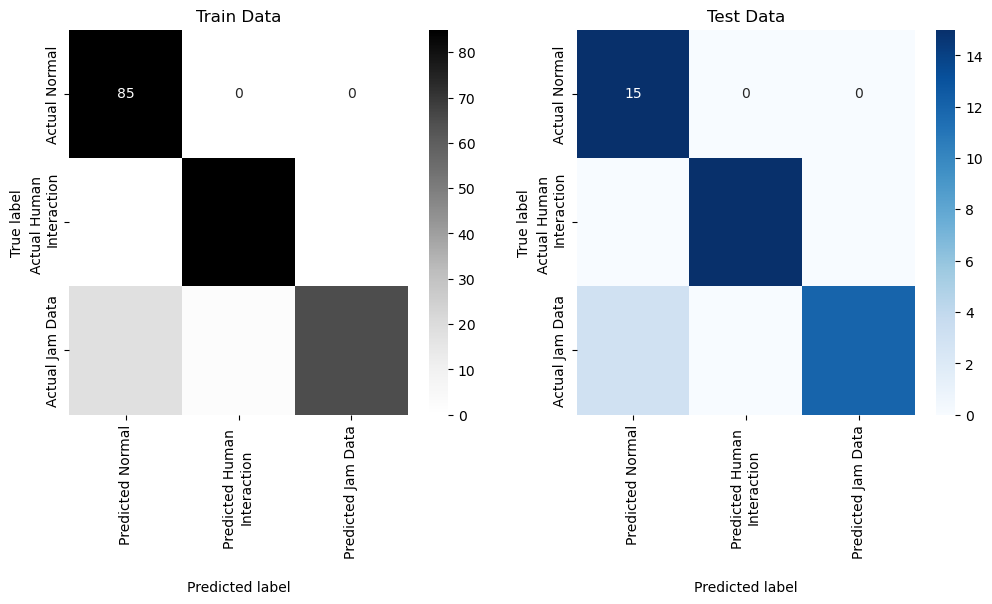

<Figure size 400x350 with 0 Axes>

<Figure size 400x350 with 0 Axes>

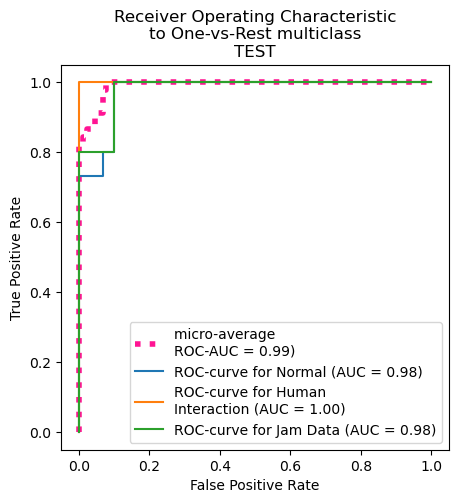

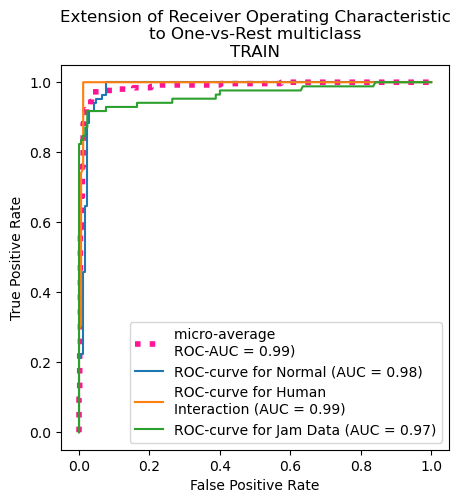

In [14]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(class_weight ='balanced',
                C=0.05,
                gamma='scale',
                kernel='rbf',
                random_state=random_state,
                probability=True))
])


df_Results, model___svm_pipeline = MultiClass_Classification_Function(
                pipeline,
                X_train, 
                X_test, 
                y_train, 
                y_test,
                class_names=["Normal",
                 "Human \nInteraction",
                 "Jam Data",
                 ]
                                                                        )

In [15]:
df_Results.reset_index().sort_values(by="index")

,index,Normal,Human \nInteraction,Jam Data,accuracy,macro avg,weighted avg
8,ROCs TEST,0.975556,1.000000,0.980000,-,0.985185,0.985185
9,ROCs TRAIN,0.982284,0.994394,0.965744,-,0.980807,0.980807
2,f1-score (TEST),0.909091,1.000000,0.888889,0.933333,0.932660,0.932660
6,f1-score (TRAIN),0.904255,0.988372,0.866667,0.921569,0.919765,0.919765
0,precision (TEST),0.833333,1.000000,1.000000,0.933333,0.944444,0.944444
4,precision (TRAIN),0.825243,0.977011,1.000000,0.921569,0.934085,0.934085
1,recall (TEST),1.000000,1.000000,0.800000,0.933333,0.933333,0.933333
5,recall (TRAIN),1.000000,1.000000,0.764706,0.921569,0.921569,0.921569
3,support (TEST),15.000000,15.000000,15.000000,0.933333,45.000000,45.000000
7,support (TRAIN),85.000000,85.000000,85.000000,0.921569,255.000000,255.000000


In [16]:
df_Results.reset_index().sort_values(by="index").shape

(10, 7)

In [17]:
model___svm_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 SVC(C=0.05, class_weight='balanced', probability=True,
                     random_state=42))])

In [18]:
from sklearn.inspection import permutation_importance


In [19]:
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=50, random_state=random_state)

# Get feature importances
feature_importances = (perm_importance.importances_mean)


In [20]:
feature_importances

array([0.06888889, 0.        , 0.01511111, 0.01555556, 0.01777778,
       0.01022222, 0.02444444, 0.192     , 0.04177778, 0.04711111,
       0.04844444, 0.05155556, 0.03422222])

In [21]:

# Normalize feature importances
total_importance = np.sum(feature_importances)
normalized_importances = (feature_importances / total_importance) * 100

# Create a DataFrame to store feature names and normalized importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': normalized_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [22]:
importance_df_SVM = importance_df.copy()

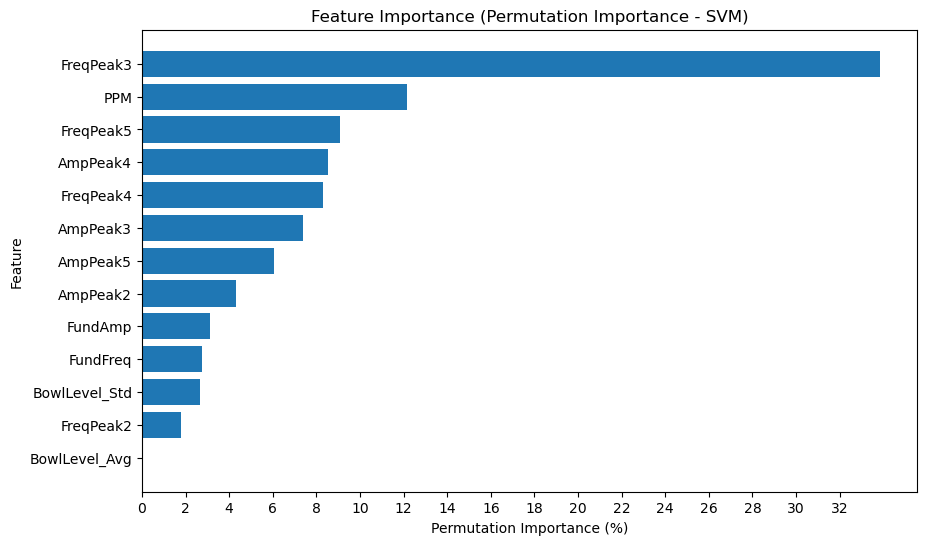

In [23]:

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Permutation Importance (%)')  # Updated xlabel
plt.ylabel('Feature')
plt.title('Feature Importance (Permutation Importance - SVM)')
plt.xticks(np.arange(0, 33, 2))  # Set x-ticks to range from 0 to 100 with a step of 10
plt.gca().invert_yaxis()  # Invert y-axis to display feature with highest importance at the top
plt.show()


# GBDT_model_pipeline
                                                                        )

[0, 1, 2] 3 ['Normal', 'Human \nInteraction', 'Jam Data']


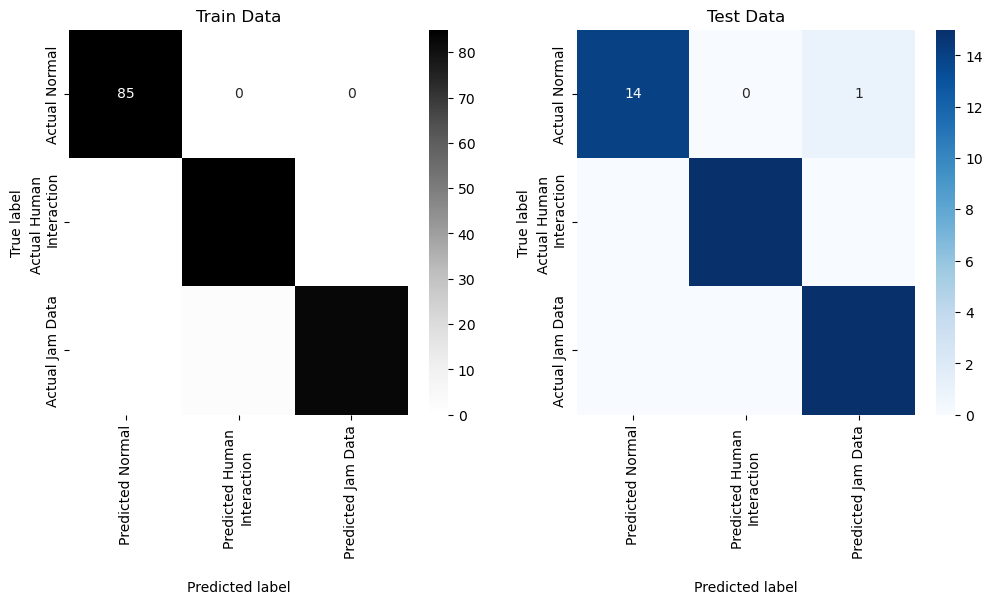

<Figure size 400x350 with 0 Axes>

<Figure size 400x350 with 0 Axes>

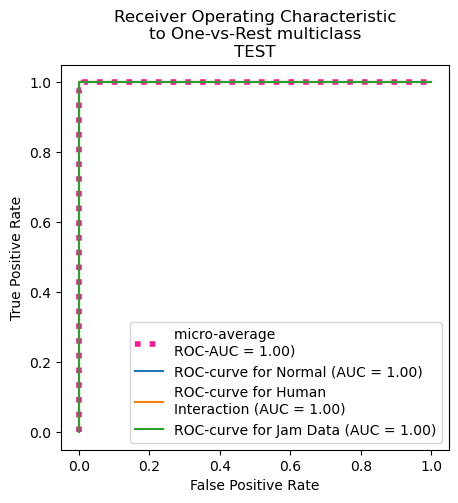

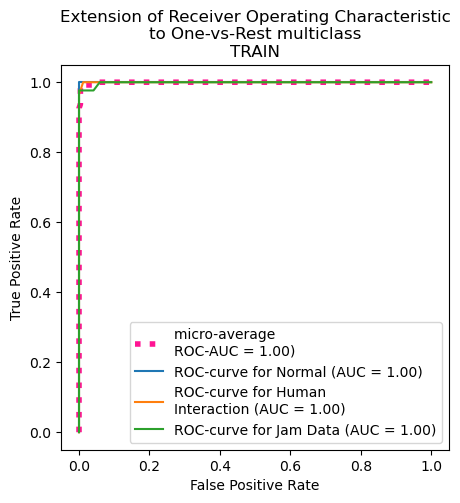

In [24]:

    GBDT_model_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gbdt', GradientBoostingClassifier(ccp_alpha = 0.005,random_state=random_state,
            **{'max_depth': 2,'n_estimators': 400}

        ))
    ])

df_Results_GBDT, model___GBDT_pipeline = MultiClass_Classification_Function(
                GBDT_model_pipeline,
                X_train, 
                X_test, 
                y_train, 
                y_test,
                class_names=["Normal",
                 "Human \nInteraction",
                 "Jam Data",
                 ]
                                                                        )

In [25]:
df_Results_GBDT.reset_index().sort_values(by="index").shape

(10, 7)

In [26]:
df_Results_GBDT.reset_index().sort_values(by="index")

,index,Normal,Human \nInteraction,Jam Data,accuracy,macro avg,weighted avg
8,ROCs TEST,1.000000,1.000000,1.000000,-,1.000000,1.000000
9,ROCs TRAIN,1.000000,0.999792,0.998824,-,0.999539,0.999539
2,f1-score (TEST),0.965517,1.000000,0.967742,0.977778,0.977753,0.977753
6,f1-score (TRAIN),1.000000,0.988372,0.988095,0.992157,0.992156,0.992156
0,precision (TEST),1.000000,1.000000,0.937500,0.977778,0.979167,0.979167
4,precision (TRAIN),1.000000,0.977011,1.000000,0.992157,0.992337,0.992337
1,recall (TEST),0.933333,1.000000,1.000000,0.977778,0.977778,0.977778
5,recall (TRAIN),1.000000,1.000000,0.976471,0.992157,0.992157,0.992157
3,support (TEST),15.000000,15.000000,15.000000,0.977778,45.000000,45.000000
7,support (TRAIN),85.000000,85.000000,85.000000,0.992157,255.000000,255.000000


In [27]:
model___GBDT_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('gbdt',
                 GradientBoostingClassifier(ccp_alpha=0.005, max_depth=2,
                                            n_estimators=400,
                                            random_state=42))])

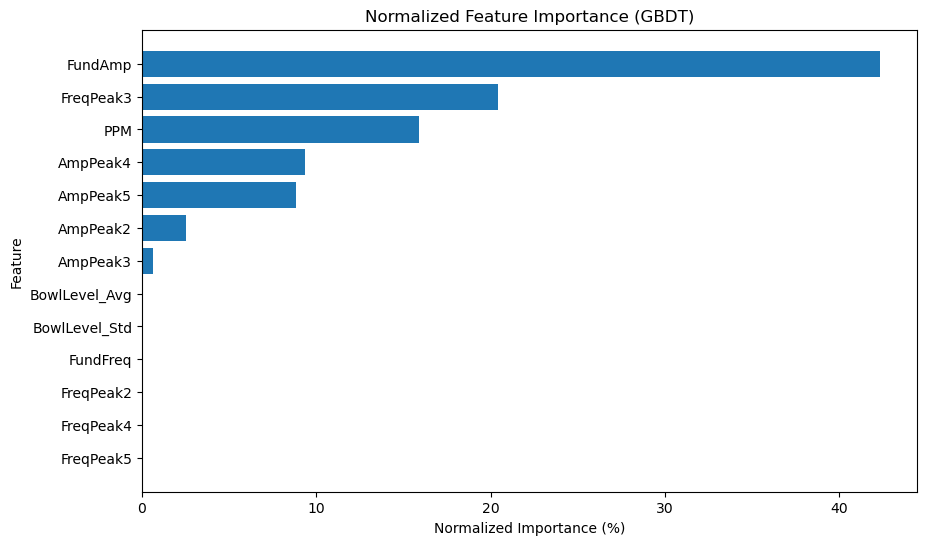

In [39]:
gbdt_model = model___GBDT_pipeline.named_steps['gbdt']

# Get feature importances
feature_importances = gbdt_model.feature_importances_

# Normalize the importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})


total_importance = importance_df['Importance'].sum()
importance_df['Normalized Importance'] = (importance_df['Importance'] / total_importance) * 100

# Sort the DataFrame by normalized importance
importance_df = importance_df.sort_values(by='Normalized Importance',ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Normalized Importance'])
plt.xlabel('Normalized Importance (%)')  # Updated xlabel
plt.ylabel('Feature')
plt.title('Normalized Feature Importance (GBDT)')
plt.xticks(np.arange(0, 50, 10))  # Set x-ticks to range from 0 to 100 with a step of 10
plt.gca().invert_yaxis()  # Invert y-axis to display feature with highest importance at the top
plt.show()


In [40]:
X.columns

Index(['PPM', 'BowlLevel_Avg', 'BowlLevel_Std', 'FundFreq', 'FundAmp',
       'FreqPeak2', 'AmpPeak2', 'FreqPeak3', 'AmpPeak3', 'FreqPeak4',
       'AmpPeak4', 'FreqPeak5', 'AmpPeak5'],
      dtype='object')

In [41]:
gbdt_model.feature_importances_

array([0.15913282, 0.        , 0.        , 0.        , 0.42344033,
       0.        , 0.025199  , 0.20409417, 0.00601484, 0.        ,
       0.09355923, 0.        , 0.0885596 ])

In [42]:
feature_importances

array([0.15913282, 0.        , 0.        , 0.        , 0.42344033,
       0.        , 0.025199  , 0.20409417, 0.00601484, 0.        ,
       0.09355923, 0.        , 0.0885596 ])

In [43]:
feature_importances

array([0.15913282, 0.        , 0.        , 0.        , 0.42344033,
       0.        , 0.025199  , 0.20409417, 0.00601484, 0.        ,
       0.09355923, 0.        , 0.0885596 ])

In [44]:
importance_df_GBDT = importance_df[["Feature","Normalized Importance"]]

In [45]:
final_importance = importance_df_GBDT.merge(importance_df_SVM)

In [46]:
importance_df_SVM

,Feature,Importance
7,FreqPeak3,33.855799
0,PPM,12.147335
11,FreqPeak5,9.090909
10,AmpPeak4,8.542320
9,FreqPeak4,8.307210
8,AmpPeak3,7.366771
12,AmpPeak5,6.034483
6,AmpPeak2,4.310345
4,FundAmp,3.134796
3,FundFreq,2.742947


In [47]:
final_importance.columns

Index(['Feature', 'Normalized Importance', 'Importance'], dtype='object')

In [48]:
final_importance.columns = ['Feature', 'GBDT Feature Importance', 'SVM Feature Importance']

# final feature importances

In [49]:
final_importance

,Feature,GBDT Feature Importance,SVM Feature Importance
0,FundAmp,42.344033,3.134796
1,FreqPeak3,20.409417,33.855799
2,PPM,15.913282,12.147335
3,AmpPeak4,9.355923,8.542320
4,AmpPeak5,8.855960,6.034483
5,AmpPeak2,2.519900,4.310345
6,AmpPeak3,0.601484,7.366771
7,BowlLevel_Avg,0.000000,0.000000
8,BowlLevel_Std,0.000000,2.664577
9,FundFreq,0.000000,2.742947
